In [1]:
import numpy as np
import torch
import jax.numpy as jnp
import jraph
import jax.random as jrandom
import jax.tree_util as tree
import jax
import haiku as hk
from typing import Any, Callable, Dict, List, Optional, Tuple
import jaxopt

import optax 
import itertools

import pickle

def load(path):
    with open(path, 'rb') as fp:
        params = pickle.load(fp)
    return params

gnn_params = load('/home/lrambelli/patternreco/params_gnn.pkl')

## loading dataset for classification GAT and MLP ###
arrays_GAT = np.load('/home/lrambelli/patternreco/arrays_layer_nhit.npy', allow_pickle = True)
X_nhit = arrays_GAT[0]  #96493
Y_nhit = arrays_GAT[1]*1e2
Z_nhit = arrays_GAT[2]
ID_nhit = arrays_GAT[3]

arrays_MLP = np.load('/home/lrambelli/patternreco/arrays_layer_nhit_internal.npy', allow_pickle = True)
X_tot = arrays_MLP[0]
Y_tot = arrays_MLP[1]
Z_tot = arrays_MLP[2]
ID_tot = arrays_MLP[3]


print('Setting parameters..') 
start_training = 0
end_training= 10000
batch_size = 1

lr = 1e-4
lr_mlp = 1e-2
steps =100

print('Events for training: ', end_training-start_training, ', batch size: ', batch_size)
print('GAT learning rate: ', lr, ' MLP learning rate: ', lr_mlp)

arrays_training_GAT = np.asarray((X_nhit[start_training:end_training], Y_nhit[start_training:end_training], Z_nhit[start_training:end_training], ID_nhit[start_training:end_training]))
arrays_training_MLP = np.asarray((X_tot[start_training:end_training], Y_tot[start_training:end_training], Z_tot[start_training:end_training], ID_tot[start_training:end_training]))

start_test = end_training + 1
end_test= start_test + 100

arrays_test_GAT = np.asarray((X_nhit[start_test:end_test], Y_nhit[start_test:end_test], Z_nhit[start_test:end_test], ID_nhit[start_test:end_test]))
arrays_test_MLP = np.asarray((X_tot[start_test:end_test], Y_tot[start_test:end_test], Z_tot[start_test:end_test], ID_tot[start_test:end_test]))


def save(params, path):
  with open(path, 'wb') as fp:
    pickle.dump(params, fp)

## functions for graph creation ##

#function that compute the node number (hit number) for each graph (event) in the batch
def get_node_number(arrays, batch_size):
    node_numbers = []
    x = arrays[0]
    
    for i in range(batch_size):
        
        xx = x[i]
        node_numbers.append([xx.shape[0]])
    max_value = np.max(node_numbers)
    #max_value = 384
    
    return node_numbers, max_value

#function that returns the n_nodes and n_edges vectors required for defining the GraphTuple
#n_nodes vector is like ([a],[b],[c]) with a,b,c nodes numbers for each graph in the batch
#n_edges vector is like ([a**2], [b**2], [c**2]) where each element is the number of edges for the graph (fully connected)

def get_nodes_edges_per_event(arrays, batch_size):
    data_array = get_node_number(arrays, batch_size)[0]

    hits_per_event = data_array
    edges_per_event = [[nhits[0]**2] for nhits in data_array]
    return hits_per_event, edges_per_event


#function that creates for each graoh in the batch the vectors defining senders and receivers
#explicitly batched graph is used so all the vectors are padded to the dimension of the bigger one 

def create_senders_receivers(arrays, batch_size):
    #nhits = get_nodes_edges_per_event(arrays, batch_size)[0]
    nhits = get_nodes_edges_per_event(arrays, batch_size)[0]
    senders = []
    receivers = []
    for nhit in nhits:
        n = nhit[0]
        s = torch.arange(n).repeat(n).tolist()
        r = torch.repeat_interleave(torch.arange(n), n).tolist()
        
        senders.append(s)
        receivers.append(r)

    padded_senders = []
    padded_receivers = []
    #max_value = 384
    max_value = get_node_number(arrays, batch_size)[1]

    for sender in senders:
        pad_s = sender + [-1] * (max_value**2 - len(sender))
        padded_senders.append(pad_s)

    for receiver in receivers:
        pad_r = receiver + [-1] * (max_value**2 - len(receiver))
        padded_receivers.append(pad_r)

    return padded_senders, padded_receivers


#function that decorates the target nodes with only the particle id (muon == -13.)
def decorate_nodes_truth(arrays, batch_size):
    nodes = []
    #max_value = 384
    max_value = get_node_number(arrays, batch_size)[1]    
    
    for i in range (0, batch_size):        
        id = np.asarray(arrays[3][i])
        id = jnp.where(jnp.absolute(id) == 13, 1, 0) #for bce

        padded_id =  jnp.pad(id, (0, max_value - len(id)), mode='constant')
        node_features = jnp.stack((padded_id), axis=-1) 
        nodes.append(node_features)

    return nodes

#function that decorates the input nodes with (y,z) coordinates
def decorate_nodes(arrays,batch_size):
    nodes = []
    max_value = get_node_number(arrays, batch_size)[1]   
    #max_value = 384 
    for i in range (0, batch_size):
        y = np.asarray(arrays[1][i])
        z = np.asarray(arrays[2][i])
                   
        pad_y =  jnp.pad(y, (0, max_value - len(y)), mode='constant')
        pad_z =  jnp.pad(z, (0, max_value - len(z)), mode='constant')
      
        padded_y = jnp.where(pad_y!=0, pad_y, 5)
        padded_z = jnp.where(pad_y!=0, pad_z, 5)

        node_features = jnp.stack((padded_y,padded_z), axis=-1)
        nodes.append(node_features)

    return nodes

def GetGraphs(arrays: np.ndarray, batch_size : int) -> jraph.GraphsTuple:
    graph = jraph.GraphsTuple(
        n_node=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[0]), 
        n_edge=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[1]), 
        nodes=jnp.array(decorate_nodes(arrays, batch_size)), 
        edges=None, 
        globals=None,  
        senders=jnp.array(create_senders_receivers(arrays, batch_size)[0]), 
        receivers=jnp.array(create_senders_receivers(arrays, batch_size)[1]))
    
    graph_truth = jraph.GraphsTuple(
        n_node=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[0]), 
        n_edge=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[1]), 
        nodes=jnp.array(decorate_nodes_truth(arrays, batch_size)), 
        edges=None, 
        globals=None,  
        senders=jnp.array(create_senders_receivers(arrays, batch_size)[0]), 
        receivers=jnp.array(create_senders_receivers(arrays, batch_size)[1]))
    
    return (graph, graph_truth)

## network definition ##

def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

#################
# GAT implementation adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L442.
def GAT(attention_query_fn: Callable,
        attention_logit_fn: Callable,
        node_update_fn: Optional[Callable] = None,
        add_self_edges: bool = True) -> Callable:
  
  # pylint: disable=g-long-lambda
  if node_update_fn is None:
    # By default, apply the leaky relu and then concatenate the heads on the
    # feature axis.
    node_update_fn = lambda x: jnp.reshape(
        jax.nn.leaky_relu(x), (x.shape[0], -1))

  def _ApplyGAT(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Attention layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    # Pass nodes through the attention query function to transform
    # node features, e.g. with an MLP.
    nodes = attention_query_fn(nodes)

    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      receivers, senders = add_self_edges_fn(receivers, senders,
                                             total_num_nodes)

    # We compute the softmax logits using a function that takes the
    # embedded sender and receiver attributes.
    sent_attributes = nodes[senders]
    received_attributes = nodes[receivers]
    att_softmax_logits = attention_logit_fn(sent_attributes,
                                            received_attributes, edges)

    # Compute the attention softmax weights on the entire tree.
    att_weights = jraph.segment_softmax(
        att_softmax_logits, segment_ids=receivers, num_segments=sum_n_node)

    # Apply attention weights.
    messages = sent_attributes * att_weights
    # Aggregate messages to nodes.
    nodes = jax.ops.segment_sum(messages, receivers, num_segments=sum_n_node)

    # Apply an update function to the aggregated messages.
    nodes = node_update_fn(nodes)

    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGAT

def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:

  def _attention_query_fn1(node_features):
        return hk.nets.MLP([4, 8, 16, 32, 64, 128, 256, 512,512, 1024])(node_features)
  
  def _attention_logit_fn1(senders, receivers, edges):
        del edges
        feat = jnp.concatenate((senders, receivers), axis=-1)
        return hk.nets.MLP([1024])(jax.nn.leaky_relu(hk.nets.MLP([1024, 512, 256, 256, 128, 128])(feat)))

  gn = GAT(
      attention_query_fn=_attention_query_fn1,

      attention_logit_fn=_attention_logit_fn1,
      node_update_fn=hk.nets.MLP([512, 256, 256, 128, 128]),
      add_self_edges=True)
  graph = gn(graph)

  def _attention_query_fn2(node_features):
        return hk.nets.MLP([128, 256, 512, 1024])(node_features)
  
  def _attention_logit_fn2(senders, receivers, edges):
        del edges
        feat = jnp.concatenate((senders, receivers), axis=-1)
        return hk.nets.MLP([128, 64, 32, 16, 8, 4, 2, 1])(jax.nn.leaky_relu(hk.nets.MLP([1024, 512, 256, 256, 128, 128])(feat)))


  gn = GAT(
      attention_query_fn=_attention_query_fn2,

      attention_logit_fn=_attention_logit_fn2,
      node_update_fn=hk.nets.MLP([1024, 512, 256, 128, 64, 32, 32, 16, 8, 4, 2, 1]),
      add_self_edges=True)
  graph = gn(graph)
 
  return graph



def func(par, X, Y):
    A, D, theta = par
    P = A * (X**2 + Y**2) + jnp.sqrt(jnp.absolute(1 + 4*A*D)) * (X * jnp.cos(theta) + Y * jnp.sin(theta)) + D
    return 2*P/(1+jnp.sqrt(1+4*A*P))

def final_params(r):
  A3 = r[0]
  D3 = r[1]
  theta3 = r[2]

  B3 = jnp.sqrt(jnp.absolute(1+4*A3*D3))*jnp.cos(theta3)
  C3 = jnp.sqrt(jnp.absolute(1+4*A3*D3))*jnp.sin(theta3)

  fitted_xcenter = -B3/(2*A3)
  fitted_ycenter = -C3/(2*A3)
  fitted_radius = 1/(2*jnp.abs(A3))
  return fitted_xcenter, fitted_ycenter, fitted_radius

def plot_circle(center_x, center_y, radius):
    theta = np.linspace(0, 2*np.pi, 1000)
    x = center_x + radius * np.cos(theta)
    y = center_y + radius * np.sin(theta)
    return x, y

def chisq_w_errors(par, x, y, w):
  y_error = 0.0005/jnp.sqrt(12)
  z_error = 0.1/jnp.sqrt(12)
  error = jnp.sqrt(y_error**2+z_error**2)
  
  residuals = func(par, x, y)
  chisq = (residuals*error)**2
  total_chisq = jnp.sum(w*chisq)
  sum_w = jnp.sum(w)

  return total_chisq / sum_w

def fit_errors(r, hessian):
    A3 = r[0]
    D3 = r[1]
    theta3 = r[2]

    A3_err = jnp.sqrt(jnp.absolute(hessian[0,0]))
    D3_err = jnp.sqrt(jnp.absolute(hessian[1,1]))
    theta3_err = jnp.sqrt(jnp.absolute(hessian[2,2]))

    fitted_xcenter_err = jnp.sqrt((A3_err ** 2 * (2 * A3 * D3 + 1) ** 2 * jnp.cos(theta3) ** 2)/(4 * A3 ** 4 * (4 * A3 * D3 + 1)) + 
                                    (theta3_err ** 2 * (4 * A3 * D3 + 1) * jnp.sin(theta3) ** 2) / (4 * A3 ** 2) + 
                                    (D3_err ** 2 * jnp.cos(theta3) ** 2) / (4 * A3 * D3 + 1))
    fitted_ycenter_err = jnp.sqrt((A3_err ** 2 * (2 * A3 * D3 + 1) ** 2 * jnp.sin(theta3) ** 2) / (4 * A3 ** 4 * (4 * A3 * D3 + 1)) + 
                                    (theta3_err ** 2 * (4 * A3 * D3 + 1) * jnp.cos(theta3) ** 2) / (4 * A3 ** 2) + 
                                    (D3_err ** 2 * jnp.sin(theta3) ** 2) / (4 * A3 * D3 + 1))
    fitted_radius_err = jnp.sqrt(A3 ** 2 * A3_err ** 2) / (2 * jnp.abs(A3) ** 3)

    return fitted_xcenter_err, fitted_ycenter_err, fitted_radius_err

def get_fit_params_and_errors(y_cluster, z_cluster):
   
    y_fit = jnp.nan_to_num(y_cluster)
    z_fit = jnp.where(y_fit != 0, z_cluster, 0)
    nan_label = jnp.ones(y_fit.shape)
    nan_label = jnp.where(y_fit != 0, nan_label, 0) 
   
    minimizer = jaxopt.BFGS(fun=chisq_w_errors)
    result = minimizer.run(jnp.array([1e-3, 0., 0.]), y_fit, z_fit, nan_label)
    fitted_xcenter, fitted_ycenter, fitted_radius = final_params(result[0])
    hessian = result.state[5]  
    fitted_xcenter_err, fitted_ycenter_err, fitted_radius_err = fit_errors(result[0], hessian)
    
    return fitted_xcenter, fitted_ycenter, fitted_radius, fitted_xcenter_err, fitted_ycenter_err, fitted_radius_err


Setting parameters..
Events for training:  10000 , batch size:  1
GAT learning rate:  0.0001  MLP learning rate:  0.01


In [2]:

def MLP_input_preprocessing(MLP_arrays, batch_size):
    coordinates = []
    labels = []

    max = get_node_number(MLP_arrays, batch_size)[1]

    for i in range (0, batch_size):
        
        y = jnp.asarray(MLP_arrays[1][i])
        z = jnp.asarray(MLP_arrays[2][i])
        id = jnp.asarray(MLP_arrays[3][i])
        id = jnp.where(jnp.absolute(id) == 13, 1, 0)

        pad_y =  jnp.pad(y, (0, max - len(y)), mode='constant')
        pad_z =  jnp.pad(z, (0, max - len(z)), mode='constant')
      
        padded_y = jnp.where(pad_y!=0, pad_y, 5)
        padded_z = jnp.where(pad_y!=0, pad_z, 5)
        padded_id =  jnp.pad(id, (0, max - len(id)), mode='constant')

        #funzioni per clustering, estrapolazione 
        input_coords = jnp.stack((padded_y,padded_z), axis=-1)
        truth_labels = jnp.stack((padded_id), axis=-1) 

        coordinates.append(input_coords)
        labels.append(truth_labels)

    return jnp.asarray(coordinates), jnp.asarray(labels)

In [3]:
@jax.jit
def cluster_hits(input_graph, output_graph):
    coordinates = input_graph.nodes
    predictions = output_graph.nodes
    y_input = coordinates[:,0]
    z_input = coordinates[:,1]

    all_weights = jnp.absolute(predictions).ravel() 
    real_weights = jnp.where(y_input != 5., all_weights, 0)
    
    layers = [2.495 , 2.505, 2.605, 2.705, 2.805, 4.205 , 4.305 ,4.405, 4.505]
    
    clustered_y = []

    for i in range(len(layers)):
      weights_layer = jnp.where(z_input == layers[i], real_weights, 0)
      y = jnp.where(z_input==layers[i], weights_layer*y_input, 0)     
      sum_w = jnp.sum(weights_layer) 
      y_mean = jnp.sum(y) / sum_w
      clustered_y.append(y_mean)
    return clustered_y, layers


def func(par, X, Y):
    A, D, theta = par
    P = A * (X**2 + Y**2) + jnp.sqrt(jnp.absolute(1 + 4*A*D)) * (X * jnp.cos(theta) + Y * jnp.sin(theta)) + D
    return 2*P/(1+jnp.sqrt(1+4*A*P))

def final_params(r):
  A3 = r[0]
  D3 = r[1]
  theta3 = r[2]

  B3 = jnp.sqrt(jnp.absolute(1+4*A3*D3))*jnp.cos(theta3)
  C3 = jnp.sqrt(jnp.absolute(1+4*A3*D3))*jnp.sin(theta3)

  fitted_xcenter = -B3/(2*A3)
  fitted_ycenter = -C3/(2*A3)
  fitted_radius = 1/(2*jnp.abs(A3))
  return fitted_xcenter, fitted_ycenter, fitted_radius

from jaxopt import ProjectedGradient
from jaxopt.projection import projection_box

@jax.jit
def get_fit_params_and_errors(y_cluster, z_cluster):
   
    y_fit = jnp.nan_to_num(y_cluster)
    z_fit = jnp.where(y_fit != 0, z_cluster, 0)
    nan_label = jnp.ones(y_fit.shape)
    nan_label = jnp.where(y_fit != 0, nan_label, 0)

    #minimizer = jaxopt.BFGS(fun=chisq_w_errors)
    #result = minimizer.run(jnp.array([1e-2, 0., 0.]),  y_fit, z_fit, nan_label)

    pg = ProjectedGradient(fun = chisq_w_errors, projection = projection_box, implicit_diff = True)
    result = pg.run(jnp.array([1e-3, 0., 0.]), hyperparams_proj = (jnp.array([1e-2, -jnp.inf, -jnp.inf]), jnp.array([jnp.inf, jnp.inf, jnp.inf])), x = y_fit, y = z_fit, w = nan_label)
    
    fitted_xcenter, fitted_ycenter, fitted_radius = final_params(result[0])
    hessian = result.state[5]  
    #fitted_xcenter_err, fitted_ycenter_err, fitted_radius_err = fit_errors(result[0], hessian)
    
    #return fitted_xcenter, fitted_ycenter, fitted_radius, fitted_xcenter_err, fitted_ycenter_err, fitted_radius_err, chisq_w_errors(jnp.array([1e-3, 0., 0.]), y_fit, z_fit, nan_label)
    return fitted_xcenter, fitted_ycenter, fitted_radius, 1, 1, 1, chisq_w_errors(jnp.array([1e-3, 0., 0.]), y_fit, z_fit, nan_label) #, fitted_xcenter_err, fitted_ycenter_err, fitted_radius_err, result

def cartesian_to_polar_GAT(y_cluster, fitted_xcenter, fitted_ycenter):
    x = jnp.asarray(y_cluster)
    y = jnp.asarray(GAT_layers)
    dx = x - fitted_xcenter
    dy = y - fitted_ycenter

    theta = jnp.nan_to_num(jnp.arctan2(dy, dx))   
    theta_ref = jnp.arctan2(fitted_xcenter, fitted_ycenter)
    theta = jnp.where(theta < theta_ref, theta + 2*jnp.pi, theta)

    return jnp.sum(theta)/jnp.count_nonzero(theta), jnp.arctan2(dy, dx)


def find_nearest_y_points(z_layer, y_layer, y_hits_layer, z_layers_hits, labels):
    num_points=5
    selected_y = []
    selected_z = []
    selected_labels = []
    selected_y_distances = []
    for i in range(len(z_layer)):
        z = z_layer[i]
        y = y_layer[i]   
        #per ogni layer prendo i valori delle y delle hit che ci stanno sopra
        y_layer_hits = jnp.where((z_layers_hits == z), y_hits_layer, 5)
        #calcolo le differenze tra questi valori e il valore estrapolato in y coord
        y_diffs = y_layer_hits - y
        abs_y_diffs = jnp.absolute(y_diffs)
        #le sorto
        sorted_indices = jnp.argsort(abs_y_diffs)

        sorted_array = y_layer_hits[sorted_indices]
        sorted_distances = y_diffs[sorted_indices]    
        
        
        sorted_label = labels[sorted_indices]

        selected_y_values = sorted_array[:num_points]
        selected_label = sorted_label[:num_points]      
        selected_z_values = z * jnp.ones_like(selected_y_values)
        selected_y_diffs = sorted_distances[:num_points]
       
        
        selected_y.append(selected_y_values)
        selected_z.append(selected_z_values)
        selected_labels.append(selected_label)
        selected_y_distances.append(selected_y_diffs)  
   

    return selected_y, selected_z, selected_labels, selected_y_distances

@jax.jit
def from_fit_to_mlp_input(MLP_coordinates, MLP_labels, fitted_xcenter, fitted_ycenter, fitted_radius, y_cluster):
    theta_mean, theta = jax.vmap(cartesian_to_polar_GAT)(y_cluster, fitted_xcenter, fitted_ycenter)
    extrapolated_theta_MLP_layers = jnp.arcsin((jnp.asarray(MLP_layers) - fitted_ycenter[:,jnp.newaxis]) / fitted_radius[:,jnp.newaxis])
    mean_extrap_theta_MLP_layers = jnp.mean(extrapolated_theta_MLP_layers, axis=1)
    theta_outer_layers = jnp.arcsin((jnp.asarray(outer_layers) - fitted_ycenter[:,jnp.newaxis]) / fitted_radius[:,jnp.newaxis])
    delta_theta_outer_layers = jnp.absolute(theta_outer_layers[:,0] - theta_outer_layers[:,1])
    good_happy_theta_inner_layers = jnp.where((jnp.absolute(mean_extrap_theta_MLP_layers - theta_mean) < 2 * delta_theta_outer_layers)[:,jnp.newaxis], extrapolated_theta_MLP_layers, jnp.pi - extrapolated_theta_MLP_layers)
    extrapolated_y_MLP_fromtheta = fitted_xcenter[:,jnp.newaxis] + fitted_radius[:,jnp.newaxis] * jnp.cos(good_happy_theta_inner_layers)  
    MLP_layers_vec = jnp.tile(jnp.asarray(MLP_layers), (batch_size, 1))
    y_mlp_input = MLP_coordinates[:,:,0]
    z_mlp_input = MLP_coordinates[:,:,1]
    mlp_labels = MLP_labels
   
    ymlp, zmlp, lmlp , ydiffmlp = jax.vmap(find_nearest_y_points)(MLP_layers_vec, extrapolated_y_MLP_fromtheta, y_mlp_input, z_mlp_input, mlp_labels)
    return ymlp, zmlp, lmlp, extrapolated_y_MLP_fromtheta, ydiffmlp


def final_MLP(x):
     return hk.nets.MLP([40, 100,  200, 400, 600,400, 200, 100, 40])(x)

@jax.jit
def update(params, opt_state, gr):
        """Returns updated params and state."""
        updates, opt_state = opt_update(gr, opt_state)
        return optax.apply_updates(params, updates), opt_state

@jax.jit
def UpdateWeights(weights,gradients):
    return weights - lr_mlp * gradients

In [4]:
GAT_layers = [2.495 , 2.505, 2.605, 2.705, 2.805, 4.205 , 4.305 ,4.405, 4.505]
MLP_layers = [0.405, 0.505, 0.605, 0.705, 0.805, 0.905, 1.005, 1.105]
outer_layers = [0.405, 4.505]

In [5]:
graph = GetGraphs(arrays_training_GAT, batch_size)[0]
graph_truth = GetGraphs(arrays_training_GAT, batch_size)[1]
dummy_mlp_input = jnp.ones((batch_size, 40))

coords, labels = MLP_input_preprocessing(arrays_training_MLP, batch_size)



In [6]:

network = hk.without_apply_rng(hk.transform(hk.vmap(gat_definition, split_rng=False)))
params = gnn_params
opt_init, opt_update = optax.adam(lr)
opt_state = opt_init(params)

second_network = hk.transform(final_MLP)
rng2 = jax.random.PRNGKey(1234)
params_mlp = second_network.init(rng2, dummy_mlp_input)
#params_mlp = load('/home/lrambelli/patternreco/training_params_end/last_params_gnn_mlp_epoch_40_loss_0.21327229_val_loss_0.3083599.pkl')

In [7]:
def DataLoader(arrays_GAT, arrays_MLP, batch_size, *, key):
    dataset_size = arrays_GAT[0].shape[0]
    #print('n_events: ', dataset_size, ', batch_size: ', batch_size)
        
    (key,) = jrandom.split(key, 1)
    start = 0
    end = batch_size
    while end <= dataset_size:
        
        yield tuple(GetGraphs(arrays_GAT[:,start:end], batch_size)), tuple(MLP_input_preprocessing(arrays_MLP, batch_size))
        start = end
        end = start + batch_size


: 

In [50]:

dataloader = DataLoader(arrays_training_GAT, arrays_training_MLP, batch_size,  key = jrandom.PRNGKey(683))
it = itertools.tee(dataloader, steps)
gpus = jax.devices('gpu')

@jax.jit
def prediction_loss(params, input_graph, target_graph):
        

        output_graph = network.apply(params, input_graph)        
        input_mask = input_graph.nodes[:,:,0]    
        radius = jnp.reshape(output_graph.nodes, (output_graph.nodes.shape[0], output_graph.nodes.shape[1]))
        
        id_mask = target_graph.nodes

        loss = (radius - id_mask)**2
        loss2 = jnp.where(input_mask != 5, loss, 0)   
        
        return jnp.sum(loss2) / jnp.count_nonzero(loss2)

@jax.jit
def mlp_loss(second_params, fit_residuals, mlp_coordinates, mlp_labels, c):
    
    y_cords = c
    mlp_labels = jnp.reshape(mlp_labels, (batch_size, 5*8))
    
    output_values = second_network.apply(second_params, rng2, mlp_coordinates)     
    
    diff = (output_values - mlp_labels)**2

    good_fit_diff = jnp.where(fit_residuals[:,jnp.newaxis] != 0, diff, 0)
    good_fit_diff = jnp.where(y_cords != 5, good_fit_diff, 0)
    

    return jnp.sum(jnp.nan_to_num(good_fit_diff)) /(jnp.count_nonzero(good_fit_diff) )

def mlp_loss_value(second_params, fit_residuals, mlp_coordinates, mlp_labels, c):
    y_cords = c
    mlp_labels = jnp.reshape(mlp_labels, (batch_size, 5*8))
    output_values = second_network.apply(second_params, rng2, mlp_coordinates)   
    diff = (output_values - mlp_labels)**2
    good_fit_diff = jnp.where(fit_residuals[:,jnp.newaxis] != 0, diff, 0)
    good_fit_diff = jnp.where(y_cords != 5, good_fit_diff, 0)
    return jnp.sum(jnp.nan_to_num(good_fit_diff)) /(jnp.count_nonzero(good_fit_diff) )


val_graph = GetGraphs(arrays_test_GAT, batch_size)[0]
val_graph_truth = GetGraphs(arrays_test_GAT, batch_size)[1]
val_coords, val_labels = MLP_input_preprocessing(arrays_test_MLP, batch_size)


print('Training')
import time 

loss_gat_list = []
loss_mlp_list = []
loss_val_mlp_list = []
count = 0
for step in range(steps):
       
        epoch_loss = 0
        mlp_epoch_loss = 0
        epoch_loss_fit = 0
        val_mlp_epoch_loss = 0
        iter_data = it[step]
        
    
        for g in iter_data:
            start = time.time()
            input_graph = g[0][0]
            truth_graph = g[0][1]
            MLP_coordinates = g[1][0]
            MLP_labels = g[1][1]

            #loss = prediction_loss(params, input_graph, truth_graph)        
            #gr = jax.grad(prediction_loss, argnums=0)(params, input_graph, truth_graph)
            #epoch_loss = loss               
            #params, opt_state = update(params, opt_state, gr)
            
            output_graph = network.apply(gnn_params, input_graph)            
            y_cluster, z_cluster = jax.vmap(cluster_hits)(input_graph, output_graph)            
            y_cluster = jnp.array(y_cluster).T
            z_cluster = jnp.array(z_cluster).T
            fitted_xcenter, fitted_ycenter, fitted_radius , fitted_xcenter_err, fitted_ycenter_err, fitted_radius_err, residuals = jax.vmap(get_fit_params_and_errors)(y_cluster/1e2, z_cluster)
            ymlp, zmlp, lmlp, extr_y_mlp, y_diff_mlp = from_fit_to_mlp_input(MLP_coordinates, MLP_labels, fitted_xcenter, fitted_ycenter, fitted_radius, y_cluster/1e2)
            ymlp = jnp.asarray(ymlp).transpose(1,0,2)  #(batch, 8, 5)
            zmlp = jnp.asarray(zmlp).transpose(1,0,2)
            lmlp = jnp.asarray(lmlp).transpose(1,0,2)
            y_diff_mlp = jnp.asarray(y_diff_mlp).transpose(1,0,2)
            
            extr_y_mlp = extr_y_mlp[:,:,jnp.newaxis] #(batch, 8, 1)
         
            ymlp = ymlp*1e2
            extr_y_mlp = extr_y_mlp*1e2

            #y_diff_mlp = extr_y_mlp - ymlp
       
            #c = jnp.stack((ymlp, zmlp), axis=1)
            #c = jnp.reshape(c, (c.shape[0], c.shape[1], 40)) 
            ymlp = jnp.reshape(ymlp, (ymlp.shape[0], 40))  
            y_diff_mlp = jnp.reshape(y_diff_mlp, (y_diff_mlp.shape[0], 40))     
                  
            #mlp_input_vector = jnp.nan_to_num(jnp.concatenate((ymlp, y_diff_mlp), axis=1)) #(batch, 8, 15)
            mlp_input_vector = y_diff_mlp*1e2
            
            #mlp_input_vector = jnp.reshape(mlp_input_vector, (batch_size, len(MLP_layers) * mlp_input_vector.shape[2])) 
            
             #(batch, 8*15)
            
            loss_mlp = mlp_loss_value(params_mlp, residuals, mlp_input_vector, lmlp, ymlp)
            gr_mlp= jax.grad(mlp_loss, argnums=0)(params_mlp, residuals, mlp_input_vector, lmlp, ymlp)            
            params_mlp = jax.tree_map(UpdateWeights, params_mlp, gr_mlp)            
            mlp_epoch_loss = loss_mlp  
            print('EVENT ', count, 'LOSS ', loss_mlp)
            count += 1
        
            loss_val = 0
            val_mlp_epoch_loss = loss_val
            
           
            
            end = time.time()

      
        #params_path = '/home/lrambelli/patternreco/training_params_end/2last_params_gnn_mlp_epoch_' + str(step) + '_loss_' + str(mlp_epoch_loss) + '_val_loss_' + str(val_mlp_epoch_loss) + '.pkl'
        #save(params_mlp, params_path)
        print('--------------------->  STEP: ', step, 'MLP LOSS: ', mlp_epoch_loss, ' VAL MLP LOSS: ', val_mlp_epoch_loss, ' TIME: ', end-start)
        loss_val_mlp_list.append(val_mlp_epoch_loss)
        loss_gat_list.append(epoch_loss)
        loss_mlp_list.append(mlp_epoch_loss)

Training
EVENT  0 LOSS  0.4061474
EVENT  1 LOSS  0.4078358
EVENT  2 LOSS  0.4068788
EVENT  3 LOSS  0.3995002
EVENT  4 LOSS  0.3952367
EVENT  5 LOSS  0.39216623
EVENT  6 LOSS  0.38579366
EVENT  7 LOSS  0.43505636
EVENT  8 LOSS  0.38099763
EVENT  9 LOSS  0.3779212
EVENT  10 LOSS  0.3733515
EVENT  11 LOSS  0.37010416
EVENT  12 LOSS  0.36471263
EVENT  13 LOSS  0.3627519
EVENT  14 LOSS  0.35925362
EVENT  15 LOSS  0.4056599
EVENT  16 LOSS  0.35160187
EVENT  17 LOSS  0.34526482
EVENT  18 LOSS  0.4088114
EVENT  19 LOSS  0.34138995
EVENT  20 LOSS  0.38133496
EVENT  21 LOSS  0.3261313
EVENT  22 LOSS  0.3194147
EVENT  23 LOSS  0.32470277
EVENT  24 LOSS  0.3170227
EVENT  25 LOSS  0.33617556
EVENT  26 LOSS  0.30191338
EVENT  27 LOSS  0.3038676
EVENT  28 LOSS  0.31028634
EVENT  29 LOSS  0.30393463
EVENT  30 LOSS  0.3327701
EVENT  31 LOSS  0.3545969
EVENT  32 LOSS  0.28844547
EVENT  33 LOSS  0.27787
EVENT  34 LOSS  0.2633989
EVENT  35 LOSS  0.15682803
EVENT  36 LOSS  0.2733421
EVENT  37 LOSS  0.27099

KeyboardInterrupt: 

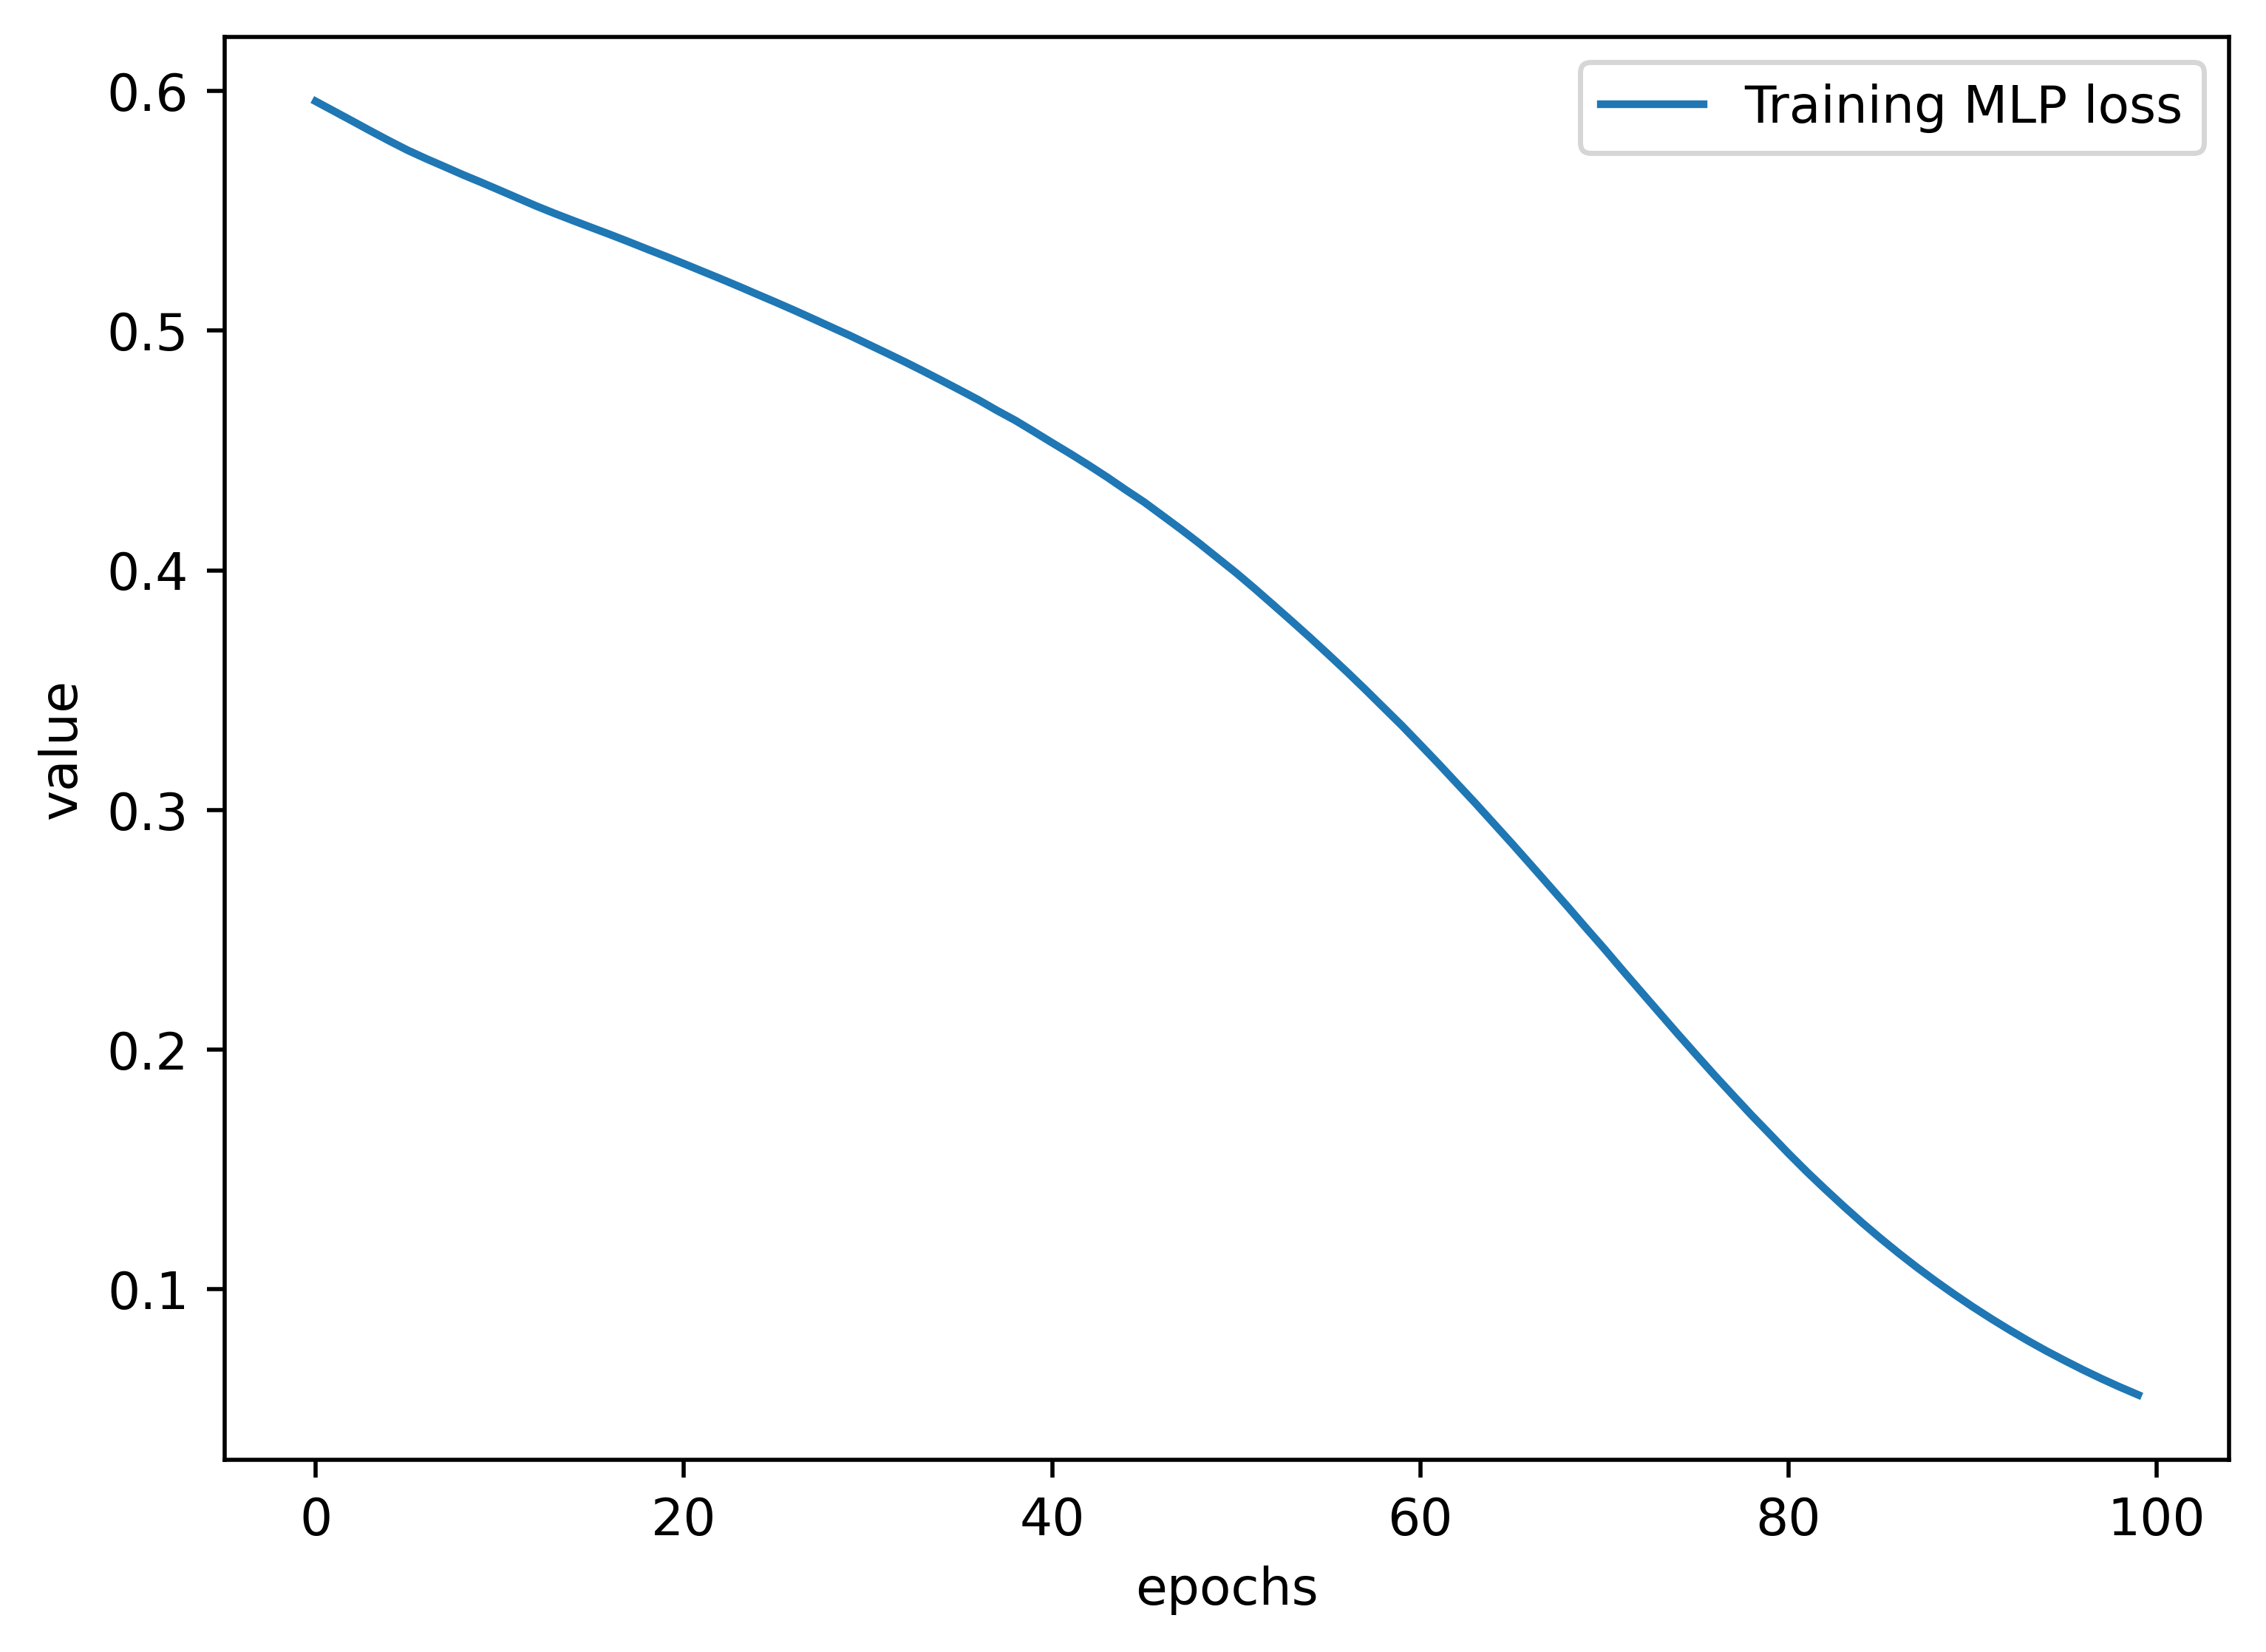

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(7, 5), dpi=500)
xrange = np.arange(0,steps,1)
#plt.plot(xrange, np.asarray(loss_val_mlp_list), label = 'Evaluation MLP loss')
plt.plot(xrange, np.asarray(loss_mlp_list), label = 'Training MLP loss')
#plt.plot(xrange, np.asarray(loss_gat_list), label = 'Training GAT loss')
plt.xlabel('epochs')
plt.ylabel('value')
plt.legend()

(4, 1)

RESIDUAL:  [5.13599e-06]
[-49.999077] [0.14219315] [50.]
[[[ 0.02326965]
  [-0.03929138]
  [-0.12207031]
  [-0.2243042 ]
  [-0.34713745]
  [-0.48980713]
  [-0.65231323]
  [-0.83465576]]]
[-0.03425    -0.0325     -0.03025    -0.028      -0.0265     -0.024
 -0.022       0.01649989  0.02        0.02325046  0.02674995  0.0813364
  0.086       0.09025006  0.09452116]


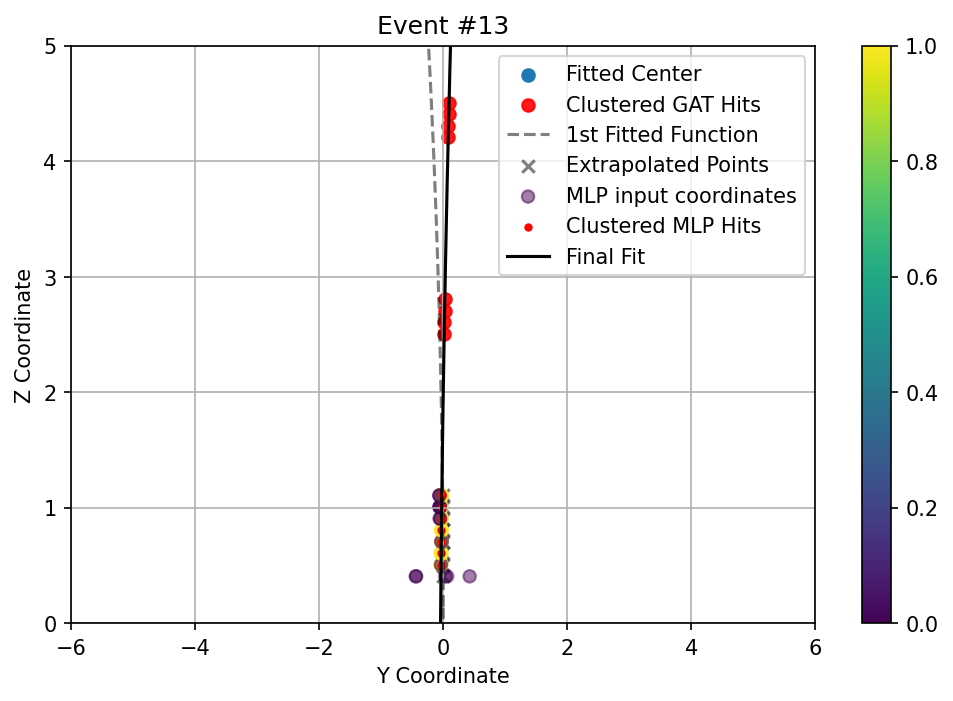

RESIDUAL:  [3.2407104e-07]
[-49.999504] [0.07959227] [50.]
[[[-0.05607605]
  [-0.13122559]
  [-0.22621155]
  [-0.3414154 ]
  [-0.47683716]
  [-0.63171387]
  [-0.8068085 ]
  [-1.0017395 ]]]
[ 0.04875     0.048       0.047       0.04625     0.0455      0.0228335
  0.02016715  0.01800021  0.01575    -0.02388877 -0.02608319 -0.02878191
 -0.03274883]


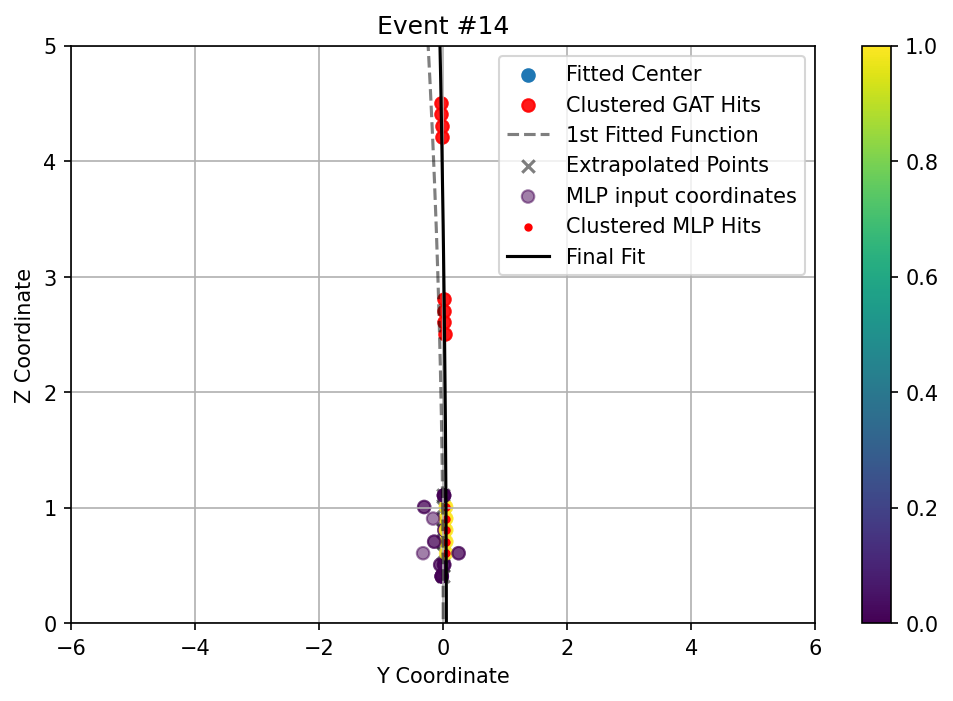

RESIDUAL:  [4.2289383e-05]
[-37.190445] [-0.08840411] [37.18984]
[[[-0.3879547]
  [-0.5340576]
  [-0.7068634]
  [-0.907135 ]
  [-1.1341095]
  [-1.3874054]
  [-1.6685486]
  [-1.9760132]]]
[-0.23575    -0.2345     -0.2325     -0.23124999 -0.22949998 -0.22924998
 -0.22774975 -0.22813308 -0.22820936 -0.2286636  -0.24604563 -0.24799997
 -0.24974996 -0.24950258]


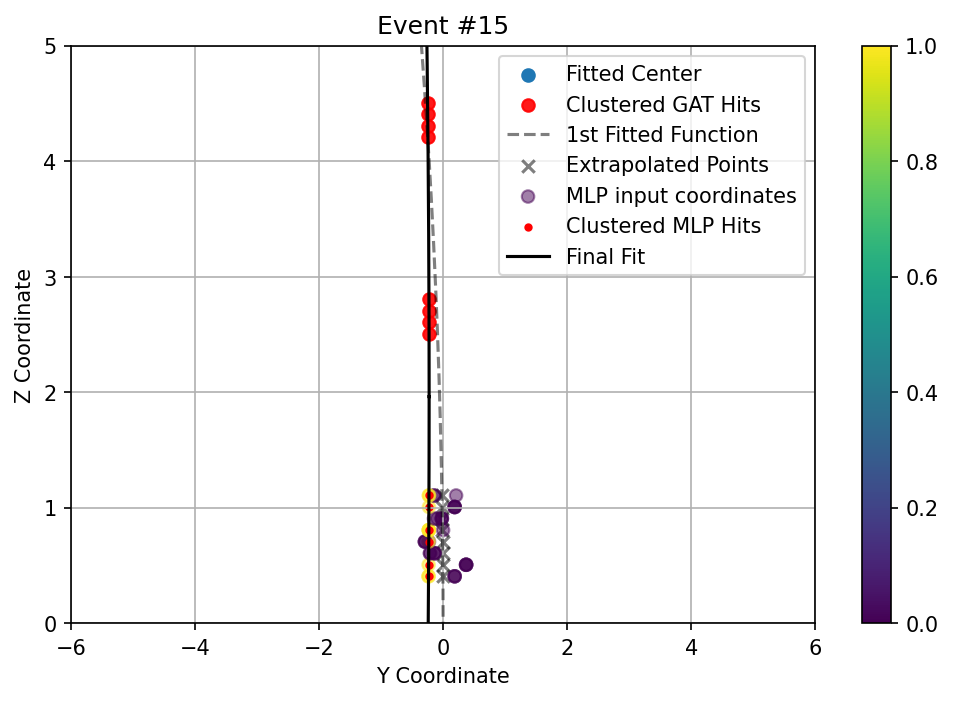

RESIDUAL:  [1.3051262e-05]
[-49.998684] [0.18558186] [50.]
[[[ 0.0831604 ]
  [ 0.02975464]
  [-0.04425049]
  [-0.13809204]
  [-0.25177002]
  [-0.38604736]
  [-0.53977966]
  [-0.71372986]]]
[0.0135     0.01525    0.017      0.0185     0.0205     0.02225
 0.0245     0.0265     0.06500002 0.068      0.0715     0.07499999
 0.133      0.13790038 0.14250003 0.14750001]


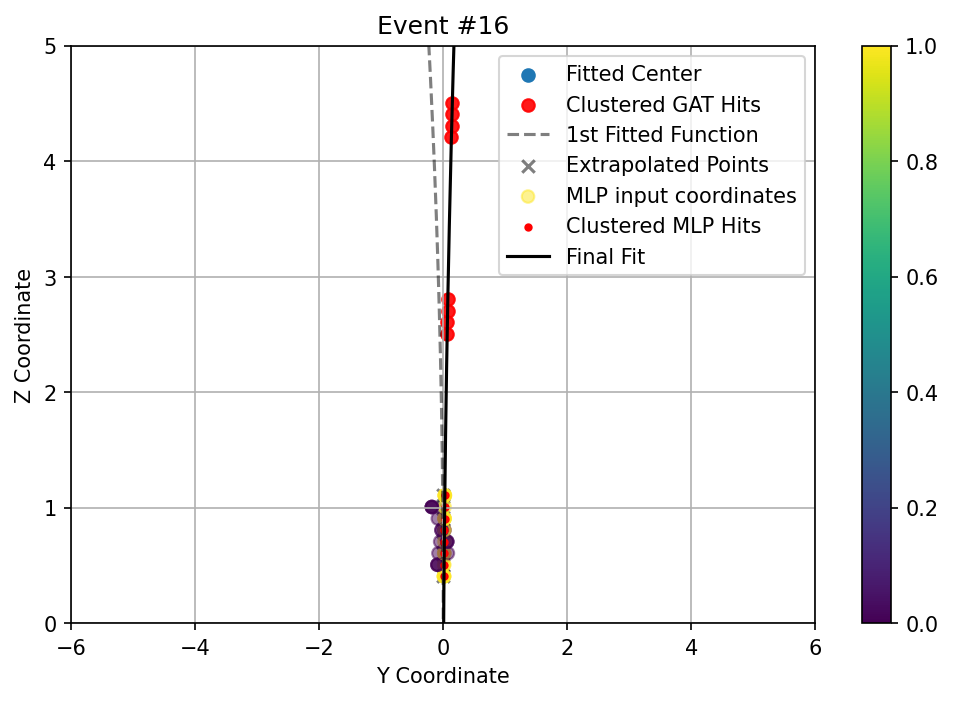

RESIDUAL:  [1.8750905e-05]
[-49.99959] [0.05838978] [50.]
[[[-0.0793457 ]
  [-0.1586914 ]
  [-0.258255  ]
  [-0.37727356]
  [-0.5168915 ]
  [-0.67596436]
  [-0.8552551 ]
  [-1.0547638 ]]]


KeyboardInterrupt: 

In [8]:
gat = hk.without_apply_rng(hk.transform(hk.vmap(gat_definition, split_rng=False)))

def clustered_mlp_points(ymlp, zmlp, output_mlp):
    
    weights = jnp.absolute(output_mlp)
    real_weights = jnp.where(ymlp != 5., weights, 0)
    layers = [0.405, 0.505, 0.605, 0.705, 0.805, 0.905, 1.005, 1.105]

    clustered_y = []
    
    for i in range(len(layers)):         
        weights_layer = jnp.where(zmlp==layers[i], real_weights, 0)
        y= jnp.where(zmlp==layers[i], weights_layer*ymlp, 0)  
        sum_w = jnp.sum(weights_layer)
        y_mean = jnp.sum(y)/sum_w
        clustered_y.append(y_mean)
    return jnp.asarray(clustered_y).T, jnp.asarray(layers).T



def plot_circle(center_x, center_y, radius):
    theta = np.linspace(0, 2*np.pi, 1000)
    x = center_x + radius * np.cos(theta)
    y = center_y + radius * np.sin(theta)
    return x, y

def chisq3(par, x, y, w):
  y_error = 0.0005/jnp.sqrt(12)
  z_error = 0.1/jnp.sqrt(12)
  error = jnp.sqrt(y_error**2+z_error**2)
  
  residuals = func(par, x, y)
  chisq = (residuals/error)**2
  total_chisq = jnp.sum(w*chisq)
  sum_w = jnp.sum(w)

  return total_chisq / sum_w

import matplotlib.pyplot as plt 

predicted_2nd_pt = []
truth_pt = []
predicted_1st_pt = []

def plot_circle(center_x, center_y, radius):
    theta = np.linspace(0, 2*np.pi, 100000)
    x = center_x + radius * np.cos(theta)
    y = center_y + radius * np.sin(theta)
    return x, y

TRUTH = []
OUTPUT = []
DISTANCES = []
for i in range(13, 18):
    batch_size = 1

    start_test = i
    end_test= i+1

    fitted_xcenter=0
    fitted_ycenter=0
    fitted_radius=0
    fitted_xcenter_err=0
    fitted_ycenter_err=0
    fitted_radius_err=0
    fitted_xcenter3 = 0
    fitted_ycenter3 = 0
    fitted_radius3 = 0

    arrays_test_GAT = np.asarray((X_nhit[start_test:end_test], Y_nhit[start_test:end_test], Z_nhit[start_test:end_test], ID_nhit[start_test:end_test]))
    arrays_test_MLP = np.asarray((X_tot[start_test:end_test], Y_tot[start_test:end_test], Z_tot[start_test:end_test], ID_tot[start_test:end_test]))
    #pt_values = arrays_pt[4][start_test:end_test]
    graph = GetGraphs(arrays_test_GAT, batch_size)[0]
    graph_truth = GetGraphs(arrays_test_GAT, batch_size)[1]
    
    
    MLP_coordinates = MLP_input_preprocessing(arrays_test_MLP, batch_size)[0]
    MLP_labels = MLP_input_preprocessing(arrays_test_MLP, batch_size)[1]
    output_graph = gat.apply(gnn_params, graph)
    
    y_cluster, z_cluster = jax.vmap(cluster_hits)(graph, output_graph)
    y_cluster = jnp.array(y_cluster).T
    z_cluster = jnp.array(z_cluster).T
    
    fitted_xcenter, fitted_ycenter, fitted_radius , fitted_xcenter_err, fitted_ycenter_err, fitted_radius_err, residuals = jax.vmap(get_fit_params_and_errors)(y_cluster/1e2, z_cluster)
    print('RESIDUAL: ', residuals)
    print(fitted_xcenter, fitted_ycenter, fitted_radius)
    
    ymlp, zmlp, lmlp, extr_y_mlp, y_diff_mlp = from_fit_to_mlp_input(MLP_coordinates, MLP_labels, fitted_xcenter, fitted_ycenter, fitted_radius, y_cluster/1e2)
    ymlp = jnp.asarray(ymlp).transpose(1,0,2)  #(batch, 8, 5)
    zmlp = jnp.asarray(zmlp).transpose(1,0,2)
    lmlp = jnp.asarray(lmlp).transpose(1,0,2)
    y_diff_mlp = jnp.asarray(y_diff_mlp).transpose(1,0,2)
    
    extr_y_mlp = extr_y_mlp[:,:,jnp.newaxis] #(batch, 8, 1)
    
    ymlp = ymlp*1e2
    extr_y_mlp = extr_y_mlp*1e2

    #diff = ymlp - extr_y_mlp
    #y_diff_mlp = diff
    print(extr_y_mlp)
          
    #c = jnp.stack((ymlp, zmlp), axis=1)
    #c = jnp.reshape(c, (c.shape[0], c.shape[1], 40)) 
    ymlp = jnp.reshape(ymlp, (ymlp.shape[0], 40))  
    y_diff_mlp = jnp.reshape(y_diff_mlp, (y_diff_mlp.shape[0], 40))     
    mlp_input_vector = y_diff_mlp*1e2         
    #mlp_input_vector = jnp.nan_to_num(jnp.concatenate((ymlp, y_diff_mlp), axis=1)) #(batch, 8, 15)
    
    #mlp_input_vector = jnp.nan_to_num(jnp.concatenate((ymlp, zmlp, y_diff_mlp), axis=2)) #(batch, 8, 15)
    DISTANCES.append(y_diff_mlp.ravel())
    TRUTH.append(lmlp.ravel())

    ymlp = jnp.reshape(ymlp, (batch_size, 40))
    zmlp = jnp.reshape(zmlp, (batch_size, 40))
    lmlp = jnp.reshape(lmlp, (batch_size, 40))
    lmlp = jnp.where(ymlp/1e2 != 5., lmlp, 0)
    
    cluster_y_mlp , cluster_z_mlp = jax.vmap(clustered_mlp_points)(ymlp, zmlp, lmlp)
    final_y = jnp.concatenate((cluster_y_mlp/1e2, y_cluster/1e2), axis=1)
    final_z = jnp.concatenate((cluster_z_mlp, z_cluster), axis=1)

    
    final_y = final_y.ravel()
    final_z = final_z.ravel()
    
    y = final_y[jnp.nan_to_num(final_y)!=0]
    z = final_z[jnp.nan_to_num(final_y)!=0]

    final_w = jnp.where(y==5, 0, 1)

    minimizer = jaxopt.BFGS(fun=chisq3)
    results3 = minimizer.run(jnp.array([1e-3, 0., 0.]), y, z, final_w)
    fitted_xcenter3, fitted_ycenter3, fitted_radius3 = final_params(results3[0])
    print(y)
    x_fun_fin, y_fun_fin = plot_circle(fitted_xcenter3, fitted_ycenter3, fitted_radius3)
    x_fun, y_fun = plot_circle(fitted_xcenter, fitted_ycenter, fitted_radius)
    

    plt.figure(figsize=(8, 5), dpi=150)
    plt.scatter(fitted_xcenter, fitted_ycenter, label = 'Fitted Center')
    plt.scatter(y_cluster/1e2, z_cluster, color = 'red', label = 'Clustered GAT Hits', alpha = 0.9)
    plt.plot(x_fun, y_fun, color = 'black',label = '1st Fitted Function', linestyle='dashed', alpha = 0.5)
    plt.scatter((extr_y_mlp/1e2).ravel(), MLP_layers, marker = 'x', color = 'black', label = 'Extrapolated Points', alpha = 0.5)  
    plt.scatter((ymlp/1e2).ravel(), zmlp.ravel(), c=lmlp.ravel(),label = 'MLP input coordinates', alpha = 0.5)
    plt.scatter((cluster_y_mlp/1e2), cluster_z_mlp, color = 'red', marker = '.', label = 'Clustered MLP Hits', alpha = 1)
    plt.plot(x_fun_fin, y_fun_fin, label = 'Final Fit', color='black')
   
   
    plt.legend()
    plt.title('Event #' + str(i))
    plt.xlabel('Y Coordinate')
    plt.ylabel('Z Coordinate')
    plt.ylim(0, 5)
    plt.xlim(-6, 6)
    plt.colorbar()
    plt.grid(True)
    plt.show()
    '''
    rng2 = jax.random.PRNGKey(1234)
    #mlp_input_vector = jnp.reshape(mlp_input_vector, (batch_size, len(MLP_layers) * mlp_input_vector.shape[2]))
    output_mlp = second_network.apply(params_mlp, rng2, mlp_input_vector)
    print('YMLP    :   ', ymlp.ravel())
    #print('DIFF MLP:   ', diff.ravel())
    print('INPUT MLP:  ', mlp_input_vector.ravel())
    print('OUTPUT MLP: ', output_mlp)
    print('TRUTH MLP:  ', lmlp.ravel())
    
    ymlp = jnp.reshape(ymlp, (batch_size, 40))
    zmlp = jnp.reshape(zmlp, (batch_size, 40))
  
    cluster_y_mlp , cluster_z_mlp = jax.vmap(clustered_mlp_points)(ymlp, zmlp, output_mlp)
  
    final_y = jnp.concatenate((cluster_y_mlp/1e2, y_cluster/1e2), axis=1)
    final_z = jnp.concatenate((cluster_z_mlp, z_cluster), axis=1)

    
    final_y = final_y.ravel()
    final_z = final_z.ravel()
    
    y = final_y[jnp.nan_to_num(final_y)!=0]
    z = final_z[jnp.nan_to_num(final_y)!=0]

    minimizer = jaxopt.BFGS(fun=chisq3)
    results3 = minimizer.run(jnp.array([1e-3, 0., 0.]), y, z)
    fitted_xcenter3, fitted_ycenter3, fitted_radius3 = final_params(results3[0])
    
    pt2=0.3*1*fitted_radius3
    #print('fit1: ', pt1*1000, ' fit2: ', pt2*1000, 'truth: ', pt_values)
    
    #truth_pt.append(pt_values)
    
    OUTPUT.append(output_mlp.ravel())
    
    x_fun_fin, y_fun_fin = plot_circle(fitted_xcenter3, fitted_ycenter3, fitted_radius3)
    x_fun, y_fun = plot_circle(fitted_xcenter, fitted_ycenter, fitted_radius)
    
    plt.figure(figsize=(8, 5), dpi=150)
    plt.scatter(y_cluster/1e2, z_cluster, color = 'red', label = 'Clustered GAT Hits', alpha = 0.9)
    plt.plot(x_fun, y_fun, color = 'black',label = '1st Fitted Function', linestyle='dashed', alpha = 0.5)
    plt.scatter((extr_y_mlp/1e2).ravel(), MLP_layers, marker = 'x', color = 'black', label = 'Extrapolated Points', alpha = 0.5)  
    plt.scatter((ymlp/1e2).ravel(), zmlp.ravel(), c=lmlp.ravel(),label = 'MLP input coordinates', alpha = 0.5)
    plt.scatter((cluster_y_mlp/1e2), cluster_z_mlp, color = 'red', marker = '.', label = 'Clustered MLP Hits', alpha = 1)
    plt.plot(x_fun_fin, y_fun_fin, label = 'Final Fit', color='black')
    plt.scatter(fitted_xcenter3, fitted_ycenter3, color = 'black', label = 'Final Fitted Center')
   
    plt.legend()
    plt.title('Event #' + str(i))
    plt.xlabel('Y Coordinate')
    plt.ylabel('Z Coordinate')
    plt.ylim(0, 1.3)
    plt.xlim(-0.15, 0.15)
   
    
    plt.colorbar()
    plt.grid(True)
    plt.show()
    '''       

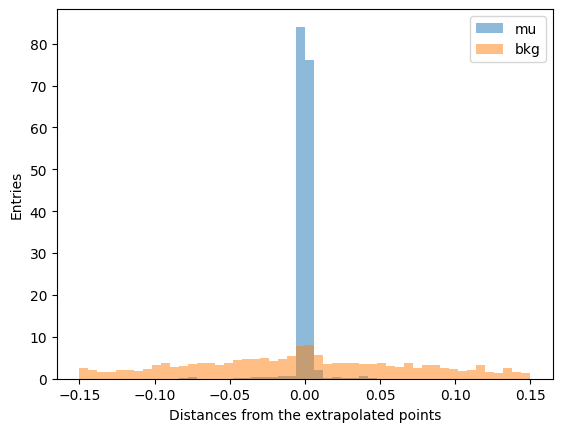

: 

In [ ]:
distances = np.asarray(DISTANCES).ravel()
truth_labels = np.asarray(TRUTH).ravel()

differences_mu = []
differences_bkg = []
for i in range(truth_labels.shape[0]):
    distance = distances[i]
    truth = truth_labels[i]
    if truth == 1:
        differences_mu.append(distance)
    if truth == 0:
        differences_bkg.append(distance)




plt.hist(differences_mu, range = [-0.15, 0.15], bins=50, alpha = 0.5, label = 'mu', density = True)
plt.hist(differences_bkg, range = [-0.15, 0.15],bins= 50, alpha = 0.5, label = 'bkg', density = True)
plt.legend()
plt.xlabel('Distances from the extrapolated points')
plt.ylabel('Entries')

plt.show()

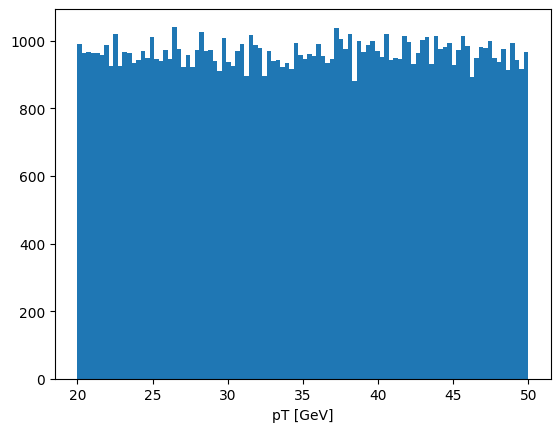

In [17]:
arrays_pt= np.load('/home/lrambelli/patternreco/arrays_layer_nhit_tot_pt.npy', allow_pickle = True)
pt = arrays_pt[4].ravel()
plt.hist(pt*0.001, bins=100)
plt.xlabel('pT [GeV]')
plt.show()